# 주제: 인물사진 만들기

## 데이터
사진 3장

## 목표
1. 아웃포커싱 효과가 적용된 인물모드 사진, 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작
2. 인물사진에서 발생한 문제점을 정확히 지적한 사진 제출
3. semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시

## 1. 인물사진
### (1) 라이브러리 및 데이터 불러오기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(168, 299, 3)


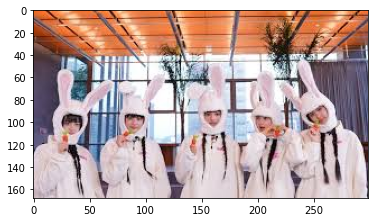

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/뉴진스토끼.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 모델 불러오기

In [5]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1b827ea6a0>)

In [6]:
model = semantic_segmentation() #PixelLib 라이브러리 이용하여 인스턴스를 만듦
model.load_pascalvoc_model(model_file) # pascal voc

### (3) image segmentation

In [7]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascal

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

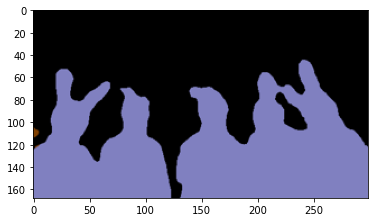

In [9]:
#이미지 분할한 뒤 출력
plt.imshow(output)
plt.show()

In [10]:
segvalues # 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 15, 20]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
tv


### (4) 사람만 추출하기

In [12]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15]

array([192, 128, 128])

In [15]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (128,128,192)

(168, 299)


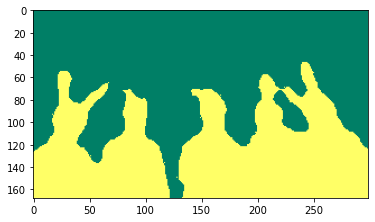

In [27]:
# seg_color 값을 제외하고 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
plt.show()

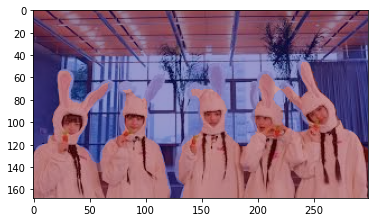

In [30]:
# 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 배경 흐리게 하기

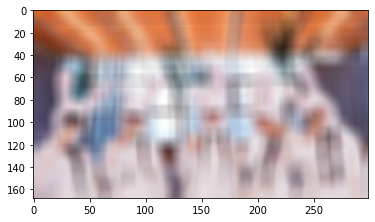

In [31]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

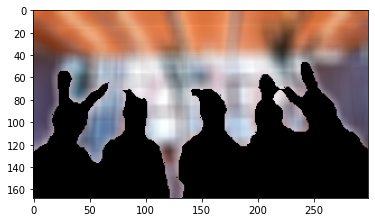

In [32]:
# BGR을 RBG로 바꾸기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (6) 흐린 배경과 원본 그림 합성

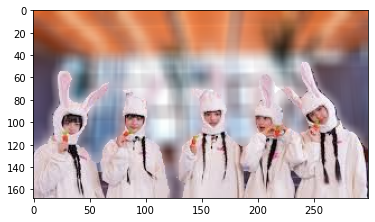

In [33]:
# 흐린 배경과 원본 그림 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (7) 문제점 발견

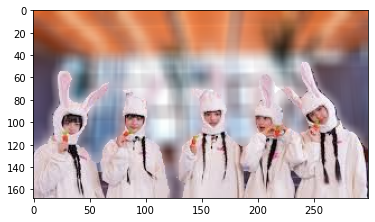

In [34]:
# 문제점 지적하는 표시하기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (8) 해결방안

1. 어쩌구저쩌구
2. 샬라샬라
3. 세개정도 잘 생각해보자

## 2. 동물사진

(183, 275, 3)
- 원본이미지


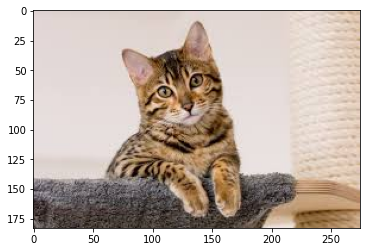

- 분할한 이미지


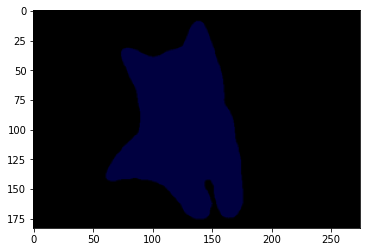

background
cat
[64  0  0]


In [46]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
print("- 원본이미지")
plt.show()

# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

# 이미지 분할
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

# segmentAsPascal
segvalues, output = model.segmentAsPascalvoc(img_path) 

# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 분할한 이미지 출력
plt.imshow(output)
print("- 분할한 이미지")
plt.show()

# 분할한 이미지 배열값 출력
segvalues 

#라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 8 고양이 12 강아지
print(colormap[8])

(183, 275)
- 분할한 이미지 선명하게 보기


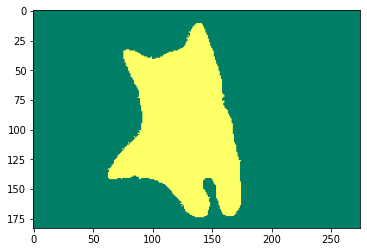

- 원본이미지의 컬러마스크


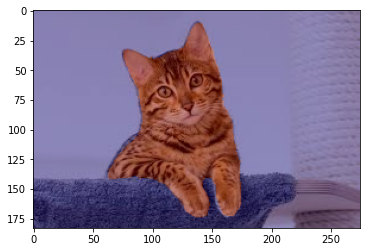

- 블러된 원본 이미지


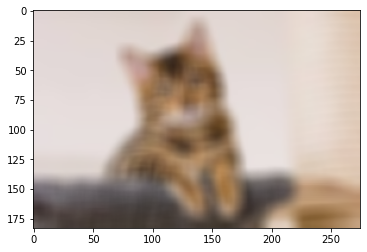

- 블러된 배경만 확인하기


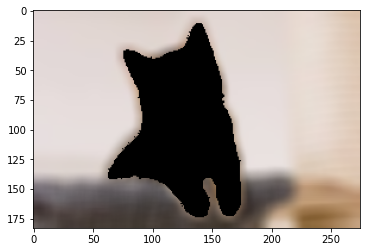

- 완성본


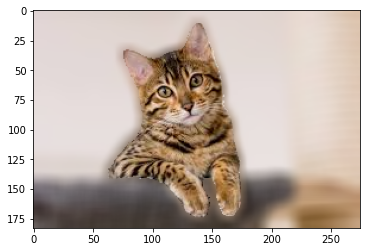

In [47]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (0, 0, 64)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

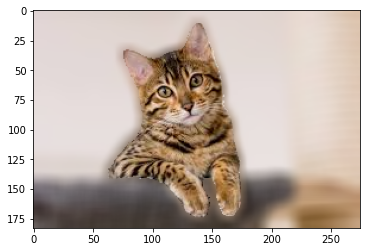

In [48]:
# 문제점 지적하는 표시하기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 해결방안
1. 어쩌구저쩌구
2. 이건 두개만 하지 ㅎㅎ

## 3. 배경 크로마키 적용하기

(177, 284, 3)
- 원본이미지


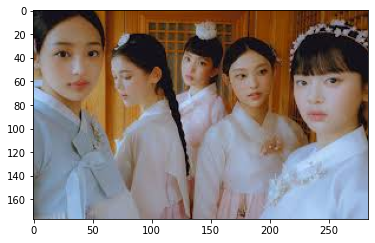

- 분할한 이미지


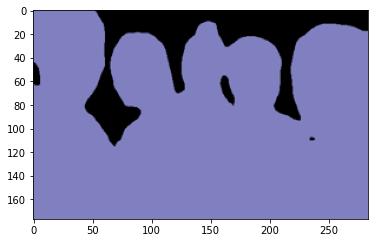

background
person
[192 128 128]


In [49]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/뉴진스한복.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
print("- 원본이미지")
plt.show()

# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

# 이미지 분할
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

# segmentAsPascal
segvalues, output = model.segmentAsPascalvoc(img_path) 

# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 분할한 이미지 출력
plt.imshow(output)
print("- 분할한 이미지")
plt.show()

# 분할한 이미지 배열값 출력
segvalues 

#라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 15 인간
print(colormap[15])

(177, 284)
- 분할한 이미지 선명하게 보기


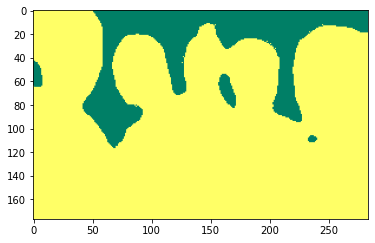

- 원본이미지의 컬러마스크


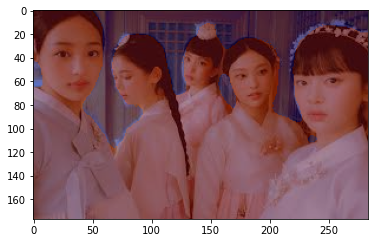

- 블러된 원본 이미지


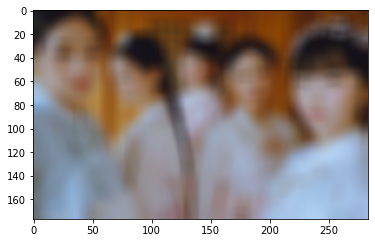

- 블러된 배경만 확인하기


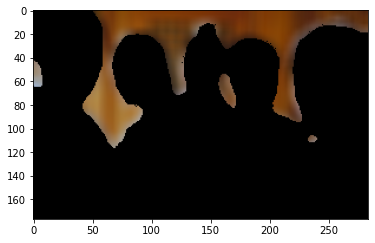

- 완성본


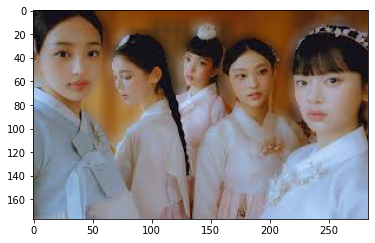

In [50]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (128, 128, 192)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

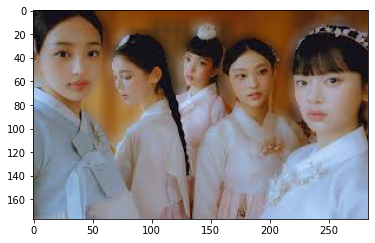

In [51]:
# 문제점 지적하는 표시하기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 해결방안
1. 어쩌구저쩌구
2. 두개만 잘해보자

# 프로젝트 회고

## 배운점

## 아쉬운점

## 종합의견

# Refernce

1. 커즈 어쩌구 저쩌구 텔미 어쩌구 하입뽀이